#**Blending - AdaBoost (Classification)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.base import clone

**Code**

In [2]:
# Load the Iris dataset (for classification)
data = load_iris()
X, y = data.data, data.target

In [3]:
# Use only 2 features for easier 2D visualization
X = X[:, :2]

In [4]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Further split the training set into a train and validation set (for blending)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [6]:
# Define base classifiers
base_classifiers = [
    ('adaboost', AdaBoostClassifier(n_estimators=50, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42)),
    ('svc', SVC(kernel='linear', probability=True))  # SVC with probability=True for blending
]

In [7]:
# Step 1: Train base classifiers on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_classifiers)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_classifiers)))  # Placeholder for test set predictions

individual_accuracies = []

for i, (name, clf) in enumerate(base_classifiers):
    # Clone the classifier to avoid overwriting during blending
    clf_instance = clone(clf)

    # Train on the full training set
    clf_instance.fit(X_train, y_train)

    # Store predictions on the validation set
    val_predictions[:, i] = clf_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = clf_instance.predict(X_test)

    # Calculate individual accuracy
    individual_pred = clf_instance.predict(X_test)
    accuracy = accuracy_score(y_test, individual_pred)
    individual_accuracies.append((name, accuracy))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [8]:
# Step 2: Blend predictions using a logistic regression model
blender = LogisticRegression()
blender.fit(val_predictions, y_val)

LogisticRegression()

In [9]:
# Step 3: Make final predictions on the test set using the blender
final_predictions = blender.predict(test_predictions)

In [10]:
# Calculate and display the accuracy of the blended model
blended_accuracy = accuracy_score(y_test, final_predictions)
print(f'Blended Model Accuracy: {blended_accuracy:.2f}')

Blended Model Accuracy: 0.80


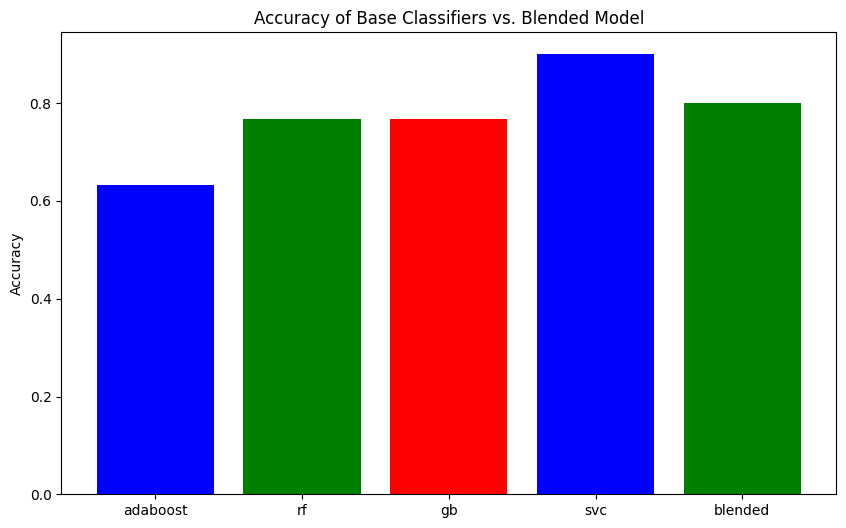

In [11]:
# Visualization of accuracies for base classifiers vs. blended model
names, accuracies = zip(*individual_accuracies)
plt.figure(figsize=(10, 6))
plt.bar(names + ('blended',), accuracies + (blended_accuracy,), color=['blue', 'green', 'red'])
plt.ylabel('Accuracy')
plt.title('Accuracy of Base Classifiers vs. Blended Model')
plt.show()

In [12]:
# Apply PCA to reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
test_predictions_2d = pca.fit_transform(test_predictions)

In [13]:
# Train a logistic regression model on the PCA-transformed data for visualization
blender_pca = LogisticRegression()
blender_pca.fit(test_predictions_2d, y_test)

LogisticRegression()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


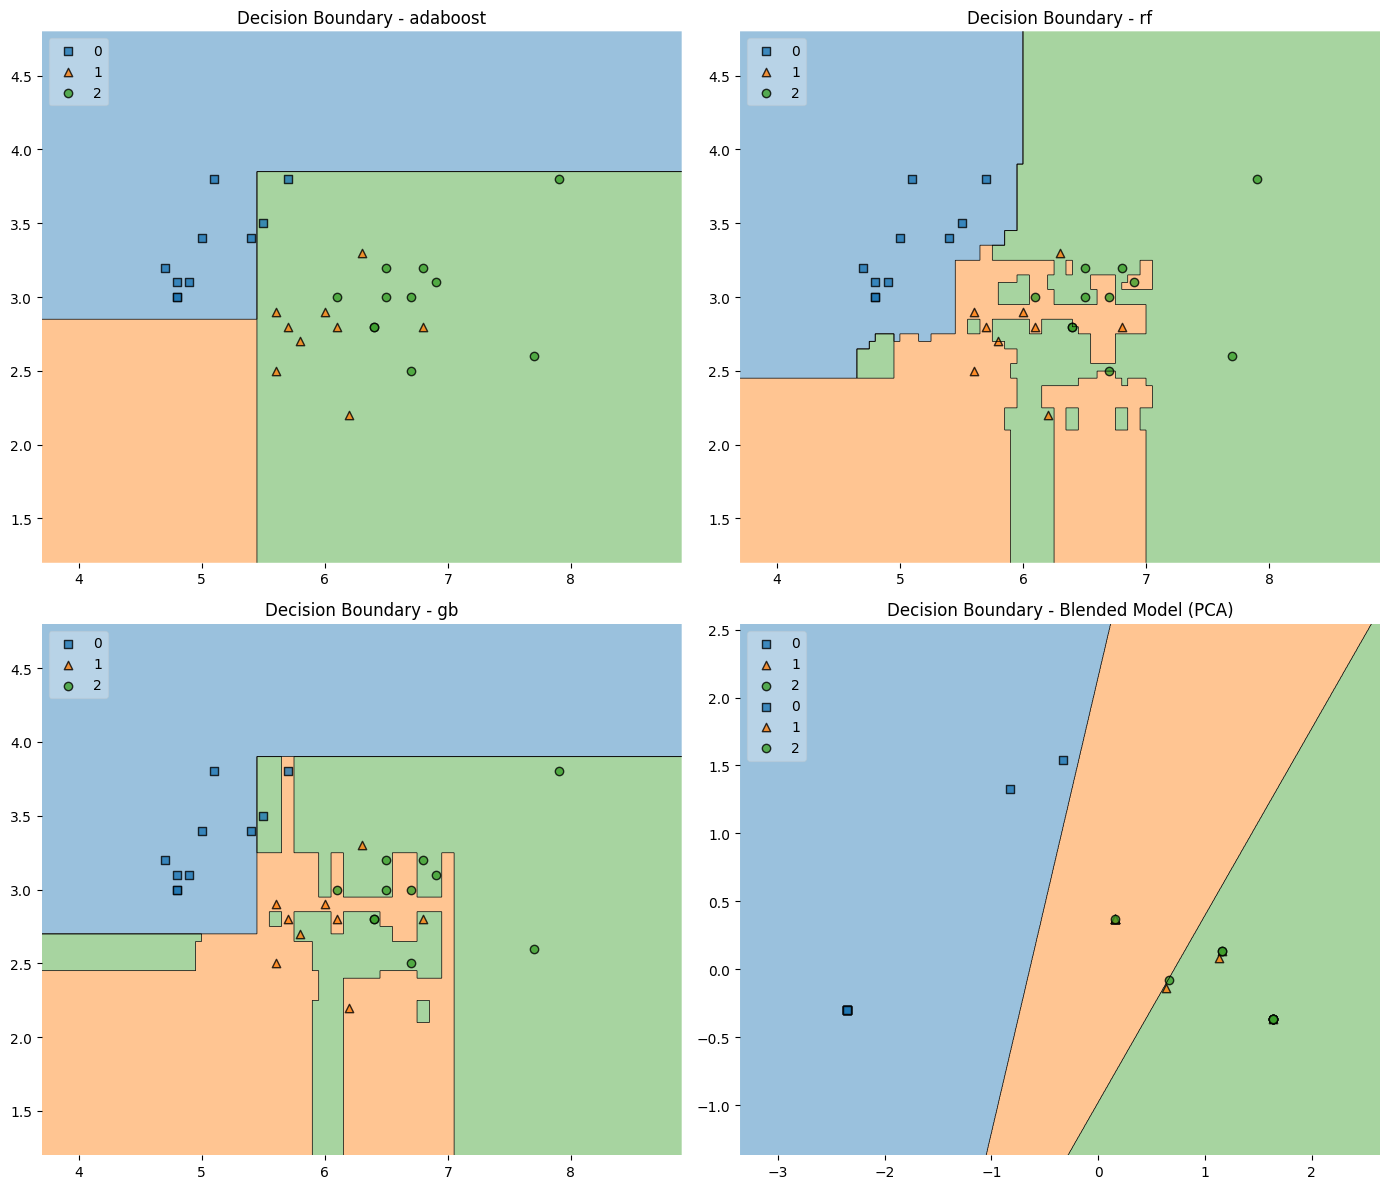

In [14]:
# Plot decision boundaries of individual classifiers and blended model (with PCA)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Plot each classifier's decision boundary
for i, (name, clf) in enumerate(base_classifiers):
    clf.fit(X_train, y_train)
    plot_decision_regions(X_test, y_test, clf=clf, ax=axes[i], legend=2)
    axes[i].set_title(f"Decision Boundary - {name}")

# Plot the PCA-transformed blended model's decision boundary
plot_decision_regions(test_predictions_2d, y_test, clf=blender_pca, ax=axes[-1], legend=2)
axes[-1].set_title(f"Decision Boundary - Blended Model (PCA)")

plt.tight_layout()
plt.show()